In [1]:
# generate the DMS protein sequence for each library
import DMS_proseq_generator
from typing import List
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
from Bio import SeqIO
from Bio.Seq import Seq
import os
import gzip

/Users/weiqiyao/opt/anaconda3/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
wt = 'MKTSEQRVNIATLLTENKKKIVDKASQDLWRRHPDLIAPGGIAFSQRDRALCLRDYGWFLHLITFCLLAGDKGPIESIGLISIREMYNSLGVPVPAMMESIRCLKEASLSLLDEEDANETAPYFDYIIKAMSEF'

In [3]:
# generate deletion library
del_smurfp_list = DMS_proseq_generator.single_aa_deletion(wt,2,len(wt))

pre deduplicate library number is :  133
The diversity of single aa deletion library is:  123


In [4]:
# generate insertion library
amino_acids = 'ARNDCQEGHILKMFPSTWYV'
ins_smurfp_list = DMS_proseq_generator.single_aa_insertion(wt,amino_acids,2,len(wt)+1)

pre deduplicate library number is :  2680
The diversity of single aa insetrion library is:  2547


In [5]:
rep_smurfp_list = DMS_proseq_generator.single_aa_replacement(wt,amino_acids,2,len(wt))

pre deduplicate library number is :  2527
The diversity of single aa replacement library is:  2527


In [6]:
# Combine all the list
DMS_proseq_list = del_smurfp_list + rep_smurfp_list + ins_smurfp_list

In [7]:
# realize for the smurfp, we did the processing of dropping the mutations that introduce Cys
DMS_order_df = pd.read_csv('20220608Synoligofinal.csv', index_col=False)
DMS_order_df = DMS_order_df.drop(DMS_order_df.columns[0], axis=1)

In [8]:
DMS_order_df.head()

,ID,length,seq
0,Alkx_Mut2-27_Asp2Cys,147,ATATAGATGCCGTCCTAGCGCCCGGTCTCCTATGTGCCGTATGCCC...
1,Alkx_Mut2-27_Asp2Ser,147,ATATAGATGCCGTCCTAGCGCCCGGTCTCCTATGTCCCGTATGCCC...
2,Alkx_Mut2-27_Asp2Gln,147,ATATAGATGCCGTCCTAGCGCCCGGTCTCCTATGCAGCGTATGCCC...
3,Alkx_Mut2-27_Asp2Met,147,ATATAGATGCCGTCCTAGCGCCCGGTCTCCTATGATGCGTATGCCC...
4,Alkx_Mut2-27_Asp2Asn,147,ATATAGATGCCGTCCTAGCGCCCGGTCTCCTATGAATCGTATGCCC...


In [9]:
def _convert_DMSoligo2aa(df):
    Geneaa_list = []
    Geneaa_df = df.copy()
    for idx, row in df.iterrows():
        DNAseq = row['seq']
        DNAseqBsaI = DNAseq.replace('GGTCTC','@').replace('GAGACC','@')
        if DNAseqBsaI.count('@') != 2:
            print('Multiple BsaI found. Check the sequence manually ')
            print('ID:' + row['ID'])
            print('Sequence' + DNAseq)
        Genechunk = DNAseqBsaI.split('@')[1][2:-2]
        Gene_aa = Seq(Genechunk).translate()
        Geneaa_list.append(str(Gene_aa))
    

    Geneaa_df['oligo_aa'] = Geneaa_list
    return Geneaa_df

In [10]:
DMS_order_df2 = _convert_DMSoligo2aa(DMS_order_df)
DMS_smurfp_order = DMS_order_df2[DMS_order_df2['ID'].str.contains('Smurfp')]
DMS_smurfp_order.head()

Multiple BsaI found. Check the sequence manually 
ID:T7lig_Mut280-306_Phe306Trp
SequenceGTGCTAAGTCACACTGTTGGTCGGTCTCCTAATGCCACCAACATTTCTCGCGCGCTTATGGACGAGTTTACCGAAACGGTTAAAGAGGCCACGTTGTCACAGTGGGGATTCTGGTCTCGGAGACCCACGCCAGTTGTGAACATAACC


/Users/weiqiyao/opt/anaconda3/lib/python3.8/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


,ID,length,seq,oligo_aa
16208,Smurfp_Mut2-27_Lys2Asp,147,AGTAGCCCACGATATCGTTTCTCGGTCTCCTATGGACACTTCTGAA...,MDTSEQRVNIATLLTENKKKIVDKASQD
16209,Smurfp_Mut2-27_Lys2Ser,147,AGTAGCCCACGATATCGTTTCTCGGTCTCCTATGTCAACTTCTGAA...,MSTSEQRVNIATLLTENKKKIVDKASQD
16210,Smurfp_Mut2-27_Lys2Gln,147,AGTAGCCCACGATATCGTTTCTCGGTCTCCTATGCAGACTTCTGAA...,MQTSEQRVNIATLLTENKKKIVDKASQD
16211,Smurfp_Mut2-27_Lys2Met,147,AGTAGCCCACGATATCGTTTCTCGGTCTCCTATGATGACTTCTGAA...,MMTSEQRVNIATLLTENKKKIVDKASQD
16212,Smurfp_Mut2-27_Lys2Asn,147,AGTAGCCCACGATATCGTTTCTCGGTCTCCTATGAATACTTCTGAA...,MNTSEQRVNIATLLTENKKKIVDKASQD


In [11]:
len(DMS_smurfp_order)

4920

In [12]:
# map the coverage of DMS NGS lib
# The reference is the protein sequence I generated
smurfp_NGS_df = pd.read_csv('final_filtered_smurfp.csv', index_col=False)
smurfp_NGS_df = smurfp_NGS_df.drop(smurfp_NGS_df.columns[0], axis=1)


In [13]:
smurfp_NGS_df.head()

,Proseq,count,Seqlen
0,MKTSEQRVNIATLLTENKKKIVDKASQDLWRRHPDLIAPGGIAFSQ...,16,134
1,MKTSEQRVNIATLLTENKKKIVDKASQDLWRRHPDLSAPGGIAFSQ...,1,134
2,MKTSEQRVNIATLLTENKKKIVDKASQDLWRRHPDLIAPGGIAFSQ...,1,135
3,MKTSEQRVNIATLLTENKKKIVDKASQDLWRHHPDLIAPGGIAFSQ...,13,134
4,MKTSEQRVNIATLLTENKKKIVDKASQDLWRRHPDLIAPGGIAFSQ...,21,135


In [18]:
# map the NGS seq with the DMS oligo seq which is translated as protein seq
NGS_proseq_list_HH = [string + 'HH' for string in smurfp_NGS_df['Proseq']]
# total coverage
Seq_not_capture = DMS_proseq_generator.DMSlib_seq_profiling(NGS_proseq_list_HH,DMS_smurfp_order['oligo_aa'])


How many seqs that is not captured in DMS NGS lib : 48
coverage of the DMS is 0.9902439024390244


In [15]:
# coveraege for single aa replacement
rep_DMS = DMS_smurfp_order[DMS_smurfp_order['length'] == 147]
Seq_not_capture_rep = DMS_proseq_generator.DMSlib_seq_profiling(NGS_proseq_list_HH,rep_DMS['oligo_aa'])

How many seqs that is not captured in DMS NGS lib : 21
coverage of the DMS is 0.9911690496215307


In [16]:
# coveraege for single aa insertion
ins_DMS = DMS_smurfp_order[DMS_smurfp_order['length'] == 150]
Seq_not_capture_ins = DMS_proseq_generator.DMSlib_seq_profiling(NGS_proseq_list_HH,ins_DMS['oligo_aa'])

How many seqs that is not captured in DMS NGS lib : 27
coverage of the DMS is 0.9888429752066116


In [17]:
# coveraege for single aa deletion
del_DMS = DMS_smurfp_order[DMS_smurfp_order['length'] == 144]
Seq_not_capture_del = DMS_proseq_generator.DMSlib_seq_profiling(NGS_proseq_list_HH,del_DMS['oligo_aa'])

How many seqs that is not captured in DMS NGS lib : 0
coverage of the DMS is 1.0


In [21]:
not_capture_df = DMS_smurfp_order[DMS_smurfp_order['oligo_aa'].isin(Seq_not_capture)]
not_capture_df.head()

,ID,length,seq,oligo_aa
16208,Smurfp_Mut2-27_Lys2Asp,147,AGTAGCCCACGATATCGTTTCTCGGTCTCCTATGGACACTTCTGAA...,MDTSEQRVNIATLLTENKKKIVDKASQD
16209,Smurfp_Mut2-27_Lys2Ser,147,AGTAGCCCACGATATCGTTTCTCGGTCTCCTATGTCAACTTCTGAA...,MSTSEQRVNIATLLTENKKKIVDKASQD
16211,Smurfp_Mut2-27_Lys2Met,147,AGTAGCCCACGATATCGTTTCTCGGTCTCCTATGATGACTTCTGAA...,MMTSEQRVNIATLLTENKKKIVDKASQD
16213,Smurfp_Mut2-27_Lys2Pro,147,AGTAGCCCACGATATCGTTTCTCGGTCTCCTATGCCCACTTCTGAA...,MPTSEQRVNIATLLTENKKKIVDKASQD
16215,Smurfp_Mut2-27_Lys2Phe,147,AGTAGCCCACGATATCGTTTCTCGGTCTCCTATGTTTACTTCTGAA...,MFTSEQRVNIATLLTENKKKIVDKASQD


In [22]:
# extract the missing mutation location and mutation
not_cap_df_info = DMS_proseq_generator.extract_mut_info(not_capture_df)
not_cap_df_info.head()
         

,ID,length,seq,oligo_aa,mut_type,mut_aa,mut_loc
16208,Smurfp_Mut2-27_Lys2Asp,147,AGTAGCCCACGATATCGTTTCTCGGTCTCCTATGGACACTTCTGAA...,MDTSEQRVNIATLLTENKKKIVDKASQD,Mut,Asp,2
16209,Smurfp_Mut2-27_Lys2Ser,147,AGTAGCCCACGATATCGTTTCTCGGTCTCCTATGTCAACTTCTGAA...,MSTSEQRVNIATLLTENKKKIVDKASQD,Mut,Ser,2
16211,Smurfp_Mut2-27_Lys2Met,147,AGTAGCCCACGATATCGTTTCTCGGTCTCCTATGATGACTTCTGAA...,MMTSEQRVNIATLLTENKKKIVDKASQD,Mut,Met,2
16213,Smurfp_Mut2-27_Lys2Pro,147,AGTAGCCCACGATATCGTTTCTCGGTCTCCTATGCCCACTTCTGAA...,MPTSEQRVNIATLLTENKKKIVDKASQD,Mut,Pro,2
16215,Smurfp_Mut2-27_Lys2Phe,147,AGTAGCCCACGATATCGTTTCTCGGTCTCCTATGTTTACTTCTGAA...,MFTSEQRVNIATLLTENKKKIVDKASQD,Mut,Phe,2


In [23]:
aalist = ['Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile',
                        'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val']

In [24]:

# dms_aa: Define all possible amino acids (adjust as needed)
# pass all possible amino acid designed in dms library and the dataframe generated above which represents counts of each unique variant seqinto the following function. Note: df has to be grouped by len for analysis.

def _missing_aa_heatmap(df, aa_list,mut_type, proseqlen):

    # Initialize a dictionary to hold the frequency data
    df2 = df[df['mut_type'] == mut_type]
    aa_matrix = {aa: [0]*proseqlen for aa in aa_list}
    # Calculate the frequency of each amino acid at each position
    for index, row in df2.iterrows():
        miss_aa = row['mut_aa']
        miss_loc = row['mut_loc']

        aa_matrix[miss_aa][int(miss_loc)] = 1


    # Convert the frequency matrix to a DataFrame for easier plotting
    aa_matrix_df = pd.DataFrame(aa_matrix)

    transposed_aa_matrix_df = aa_matrix_df.transpose()
    return transposed_aa_matrix_df

In [25]:
_missing_aa_heatmap(not_cap_df_info, aalist, 'Mut',134).head()

,0,1,2,3,4,5,6,7,8,9,...,124,125,126,127,128,129,130,131,132,133
Ala,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arg,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Asn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Asp,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cys,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


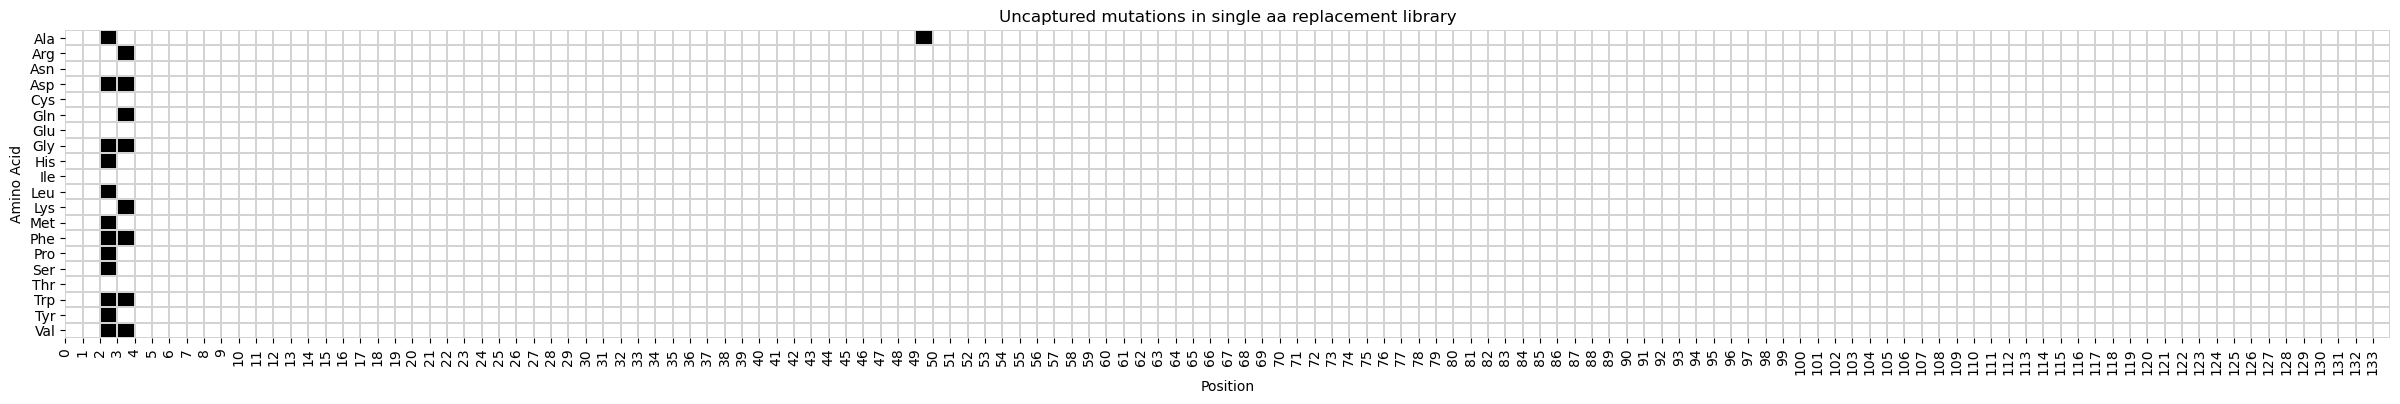

In [34]:
# Plotting the heatmap to represent missing variants in rep library
plt.figure(figsize=(30, 4))
sns.heatmap(_missing_aa_heatmap(not_cap_df_info, aalist, 'Mut',134), cmap='binary',cbar=False, annot=False,linewidths=0.1, linecolor='lightgray')
plt.title('Uncaptured mutations in single aa replacement library')
plt.xlabel('Position')
plt.ylabel('Amino Acid')
plt.xticks(range(0, 134, 1),labels=range(0, 134, 1))
plt.savefig('uncaptured_aa_in_smurfp_replib.jpg',transparent = None)
plt.show()


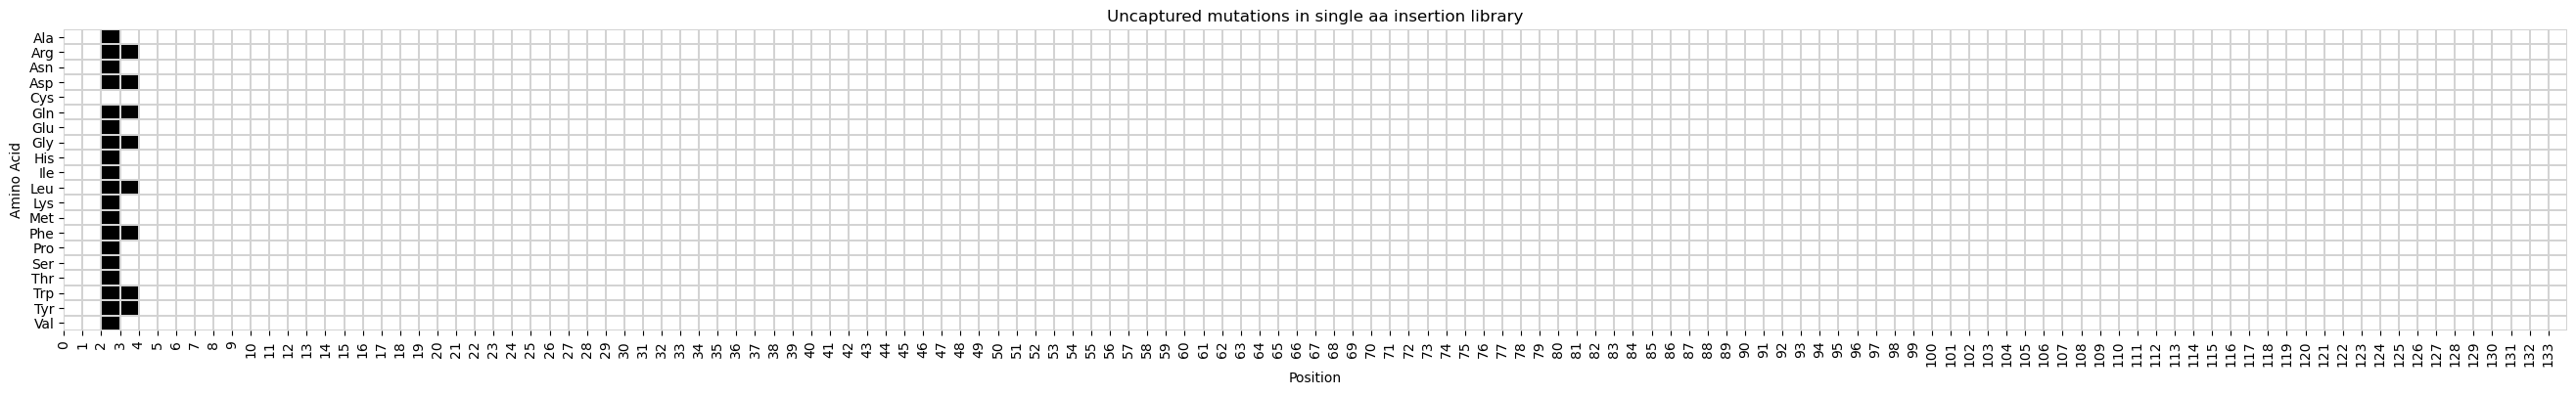

In [35]:
# Plotting the heatmap to represent missing variants in ins library
plt.figure(figsize=(33, 4))
sns.heatmap(_missing_aa_heatmap(not_cap_df_info, aalist, 'Ins',134), cmap='binary',cbar=False, annot=False,linewidths=0.1, linecolor='lightgray')
plt.title('Uncaptured mutations in single aa insertion library')
plt.xlabel('Position')
plt.ylabel('Amino Acid')
plt.xticks(range(0, 134, 1),labels=range(0, 134, 1))
plt.savefig('uncaptured_aa_in_smurfp_inslib.jpg',transparent = None)
plt.show()

